In [1]:
from pprint import pprint
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential, activations
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_variables_and_size():
    from sys import getsizeof
    names = []
    sizes = []
    types = []
    for name in dir():
        # Print the item if it doesn't start with '__'
        if not name.startswith('__'):
            value = eval(name)
            names.append(name)
            sizes.append(getsizeof(value))
            types.append(type(value))
    sort_indexes = np.argsort(sizes)[::-1]
    names = np.array(names)[sort_indexes]
    sizes = np.array(sizes)[sort_indexes]
    types = np.array(types)[sort_indexes]
    for n,s,t in zip(names,sizes,types):
        print(n, "\n\tsize :", s, "\n\ttype :", t)

In [3]:
def m_mape(y_true,y_predict):
    n = len(y_true)
    y_true = np.array(y_true) + 1
    y_predict = np.array(y_predict) + 1

    res = ((100/n)*(np.sum(np.abs((y_predict-y_true)/y_true))))
    return res

In [4]:
def box_plot(prediction_df):
    y_upper_bound = min(prediction_df["ground_truth"].max(), prediction_df["Prediction"].max())
    mape_score = m_mape(prediction_df["ground_truth"],prediction_df["Prediction"])

    plt.figure(figsize=(20,10))
    plt.suptitle("Prediction on 2017 data.")

    plt.subplot(2,3,1)
    plt.title("ground_truth")
    plt.boxplot(prediction_df["ground_truth"])
    plt.ylim([-0.01,y_upper_bound])

    plt.subplot(2,3,2)
    plt.title("Prediction. MAPE : {:.2f}".format(mape_score))
    plt.boxplot(prediction_df["Prediction"])
    plt.ylim([-0.01,y_upper_bound])

    plt.subplot(2,3,3)
    plt.boxplot(prediction_df["reg_pred"])
    plt.title("Regression only. MAPE : {:.2f}".format(m_mape(prediction_df["ground_truth"],prediction_df["reg_pred"])))
    plt.ylim([-0.01, y_upper_bound])

    plt.subplot(2,3,4)
    plt.hist(prediction_df["ground_truth"], bins=100)

    plt.subplot(2,3,5)
    plt.hist(prediction_df["Prediction"], bins=100)

    plt.subplot(2,3,6)
    plt.hist(prediction_df["reg_pred"], bins=100)

    plt.show()

In [5]:
# Creating model using the Sequential in tensorflow
def build_model_classf(*layers, loss ='binary_crossentropy', metrics = ("AUC","accuracy"), learning_rate=0.001, last_activation="softmax"):
    model = Sequential()
    model.add(layers[0])
    for layer in layers[1:]:
        model.add(layer)
    model.add(Dense(2, activation=last_activation))

    model.compile(
        loss=loss,
        optimizer=Adam(learning_rate=learning_rate),
        metrics=metrics
    )

    print(model.summary())
    return model

def make_cls_model(*layers,x,y,x_val=None,y_val=None,val_split=0.15, epochs=15, batch_size=64, learning_rate=0.001, last_activation="softmax"):
    # build the model
    model_cls = build_model_classf(*layers, learning_rate=learning_rate, last_activation=last_activation)
    # train the model
    if x_val is None :
        history_cls = model_cls.fit(
            x=x.values,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split
            # validation_data=(x_test,y_cls_test)
            )
    else :
        history_cls = model_cls.fit(
            x=x.values,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            # validation_split=0.15
            validation_data=(x_val,y_val)
            )
    return history_cls,model_cls

def plot_history_cls(history, loss, key1, key2):
    plt.figure(figsize=(17,5))
    plt.subplot(1,3,1)
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])

    plt.subplot(1,3,2)
    plt.title("metric : {}".format(key1))
    plt.plot(history.history[key1])
    plt.plot(history.history['val_'+key1])
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel(key1)
    plt.legend([key1, 'val_'+key1])

    plt.subplot(1,3,3)
    plt.title("metric : {}".format(key2))
    plt.plot(history.history[key2.lower()])
    plt.plot(history.history['val_'+key2.lower()])
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel(key2)
    plt.legend([key2, 'val_'+key2])

    plt.suptitle("Classification results")
    plt.show()

In [6]:
# Creating model using the Sequential in tensorflow
def build_model_regrs(*layers, metric = MeanSquaredError(), learning_rate=0.001, last_activation="relu"):
    model = Sequential()
    model.add(layers[0])
    for layer in layers[1:]:
        model.add(layer)
    model.add(Dense(1, activation=last_activation))

    model.compile(
        loss=metric,
        optimizer=Adam(learning_rate=learning_rate),
        metrics=[metric]
    )

    print(model.summary())
    return model

def make_reg_model(*layers,x,y,x_val=None,y_val=None,val_split=0.15, epochs=15, batch_size=64, learning_rate=0.001, last_activation="relu"):
    # build the model
    model_reg = build_model_regrs(*layers, learning_rate=learning_rate, last_activation=last_activation)
    # train the model
    if x_val is None :
        history_reg = model_reg.fit(
            x=x.values,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=val_split
            # validation_data=(x_test,y_cls_test)
            )
    else :
        history_reg = model_reg.fit(
            x=x.values,
            y=y,
            epochs=epochs,
            batch_size=batch_size,
            # validation_split=0.15
            validation_data=(x_val,y_val)
            )
    return history_reg,model_reg

def plot_history_reg(history, loss : str):
    plt.figure(figsize=(7,5))
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(np.linspace(0,len(history.history["loss"]),10,dtype=int))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])
    plt.show()

In [7]:
# custom activation functions
exp_relu = lambda x : np.exp(activations.relu(x)) - 1
square_relu = lambda x : activations.relu(x)**2

# Load the dataset

In [8]:
df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final_by_day.zip")
# df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final.zip")
df_train["raining"] = df_train["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_train["not_raining"] = 1-df_train["raining"]

x_train, y_reg_train, y_cls_train = df_train.drop(["ground_truth","not_raining","raining"], axis=1), df_train["ground_truth"], df_train[["not_raining","raining"]].to_numpy()
del df_train

In [9]:
df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final_by_day.zip")
# df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final.zip")
# get rows for computing MAPE on test
prediction_x_test = pd.DataFrame(df_test[["Id","ground_truth"]])

df_test["raining"] = df_test["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_test["not_raining"] = 1-df_test["raining"]

x_test, y_reg_test, y_cls_test = df_test.drop(["ground_truth","not_raining","raining"], axis=1), df_test["ground_truth"], df_test[["not_raining","raining"]].to_numpy()
del df_test

# Add classification label (raining or not)

In [10]:
# define the unnecessary columns
cols_to_drop = {"day","Id", "station_id","month","longitude_idx","latitude_idx", "next hour precipitation (kg/m^2)", "wind_direction (deg)"}

In [11]:
#drop unnecessary columns
x_train.drop(list(set(x_train.columns)&cols_to_drop), axis=1, inplace=True)

In [12]:
#drop unnecessary columns
x_test.drop(list(set(x_test.columns)&cols_to_drop), axis=1, inplace=True)


# get same columns on both datasets

In [13]:
columns = list(x_train.columns)
x_train = x_train[columns]
x_test = x_test[columns]

# normalize both dataset with 2016 min and min-max values

In [14]:
def get_normalization_infos(*x_s, columns):
    normalization_infos = pd.DataFrame(data=[[1000 for _ in range(len(columns))],[0 for _ in range(len(columns))]],
                                     index=["min","max"],
                                     columns=columns)
    for x in x_s :
        for col in columns:
            min_value = min(normalization_infos[col]["min"], x[col].min())
            max_value = max(normalization_infos[col]["max"], x[col].max())
            normalization_infos[col] = [min_value, max_value]

    normalization_infos.loc["spread"] = normalization_infos.apply(lambda c : c["max"] - c["min"], axis=0)

    return normalization_infos

normalization_infos = get_normalization_infos(x_train, x_test, columns=columns)

In [15]:
def normalize(x : pd.DataFrame, normalization_infos : pd.DataFrame):
    for col in x.columns:
        x[col] = (x[col] - normalization_infos[col]["min"])/normalization_infos[col]["spread"]
    return x

x_train = normalize(x_train, normalization_infos)
x_test = normalize(x_test, normalization_infos)

# see if the data is balanced raining-wise

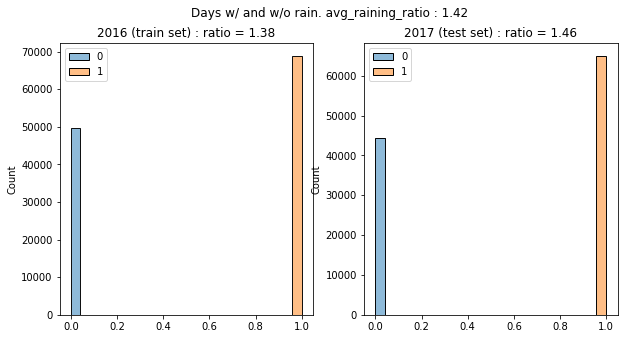

In [16]:
raining_ratio1 = y_cls_train[:,1].sum()/y_cls_train[:,0].sum()
raining_ratio2 = y_cls_test[:,1].sum()/y_cls_test[:,0].sum()
avg_raining_ratio = (raining_ratio1+raining_ratio2)/2

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(x=y_cls_train[:,1],hue=y_cls_train[:,1])
plt.title("2016 (train set) : ratio = {:.2f}".format(raining_ratio1))
plt.subplot(1,2,2)
sns.histplot(x=y_cls_test[:,1], hue=y_cls_test[:,1])
plt.title("2017 (test set) : ratio = {:.2f}".format(raining_ratio2))
plt.suptitle("Days w/ and w/o rain. avg_raining_ratio : {:.2f}".format(avg_raining_ratio))
plt.show()

ratio = 0.13 for both 2016 and 2017 ==> **Unbalanced**

# Classification Model (raining or not)
source : https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/

In [17]:
history_cls, model_cls = make_cls_model(
    Dense(128, activation="relu",input_dim=x_train.shape[1]),
    Dropout(0.1),
    Dense(64, activation="relu"),
    # Dropout(0.2),
    Dense(32, activation="relu"),
    # Dropout(0.2),
    Dense(32, activation="relu"),
    # Dropout(0.2),
    Dense(16, activation="relu"),
    x=x_train,y=y_cls_train,
    epochs=15,
    batch_size=128
)

2022-01-09 12:52:15.494196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 12:52:15.539346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-01-09 12:52:15.539365: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-01-09 12:52:15.540045: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12544     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 2)                 3

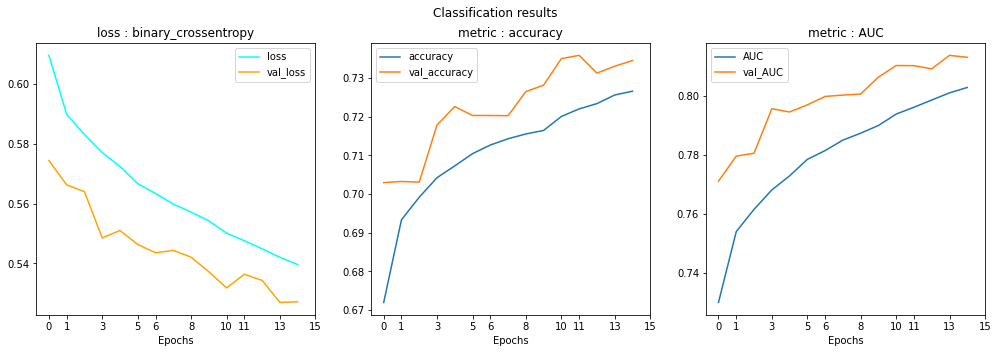

In [18]:
# Plot history
plot_history_cls(history_cls, loss = "binary_crossentropy", key1 = 'accuracy', key2 = 'AUC')

# Regression Model (how much rain if > 0)
source : https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

In [19]:
history_reg, model_reg = make_reg_model(
    Dense(128, activation="relu",input_dim=x_train.shape[1]),
    Dropout(0.1),
    Dense(64, activation="relu"),
    # Dropout(0.1),
    Dense(32, activation="relu"),
    # Dropout(0.1),
    Dense(32, activation="relu"),
    # Dropout(0.1),
    Dense(16, activation="relu"),
    x=x_train,y=y_reg_train,
    last_activation=square_relu,
    epochs=30,
    batch_size=128,
    learning_rate=0.0001
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               12544     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 32)                1056      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                

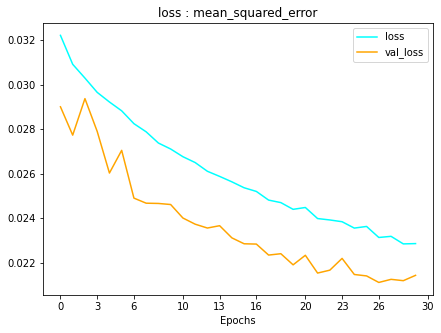

In [20]:
# Plot history
plot_history_reg(history_reg, 'mean_squared_error')

# Compute MAPE on 2017 dataset before submitting

In [21]:
del x_train
del y_cls_train
del y_reg_train

In [22]:
y_cls_pred = model_cls.predict(x_test)

In [23]:
y_reg_pred = model_reg.predict(x_test)

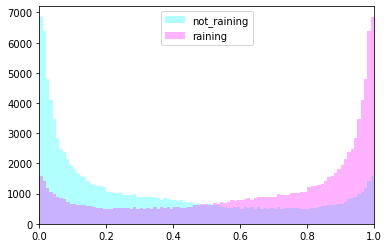

In [24]:
plt.hist(y_cls_pred[:,0], color="cyan", alpha=0.3, bins=100, label="not_raining")
plt.hist(y_cls_pred[:,1], color="magenta", alpha=0.3, bins=100, label="raining")
plt.xlim([0,1])
plt.legend()
plt.show()

In [25]:
cls_temp = y_cls_pred[:,0] < y_cls_pred[:,1]
y_cls_pred = np.array([0 if c else 1 for c in cls_temp])

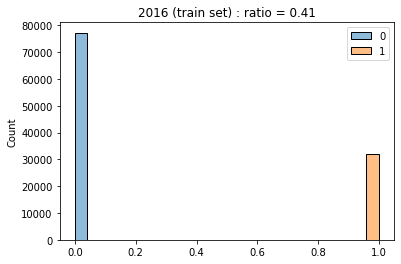

In [26]:
raining_ratio_pred = y_cls_pred.sum()/(len(y_cls_pred) - y_cls_pred.sum())
plt.title("2016 (train set) : ratio = {:.2f}".format(raining_ratio_pred))
sns.histplot(x=y_cls_pred,hue=y_cls_pred)
plt.show()

In [27]:
prediction_x_test["reg_pred"] = pd.Series(y_reg_pred.T[0])
prediction_x_test["cls_pred"] = y_cls_pred
prediction_x_test["Prediction"] = prediction_x_test["reg_pred"] * prediction_x_test["cls_pred"]

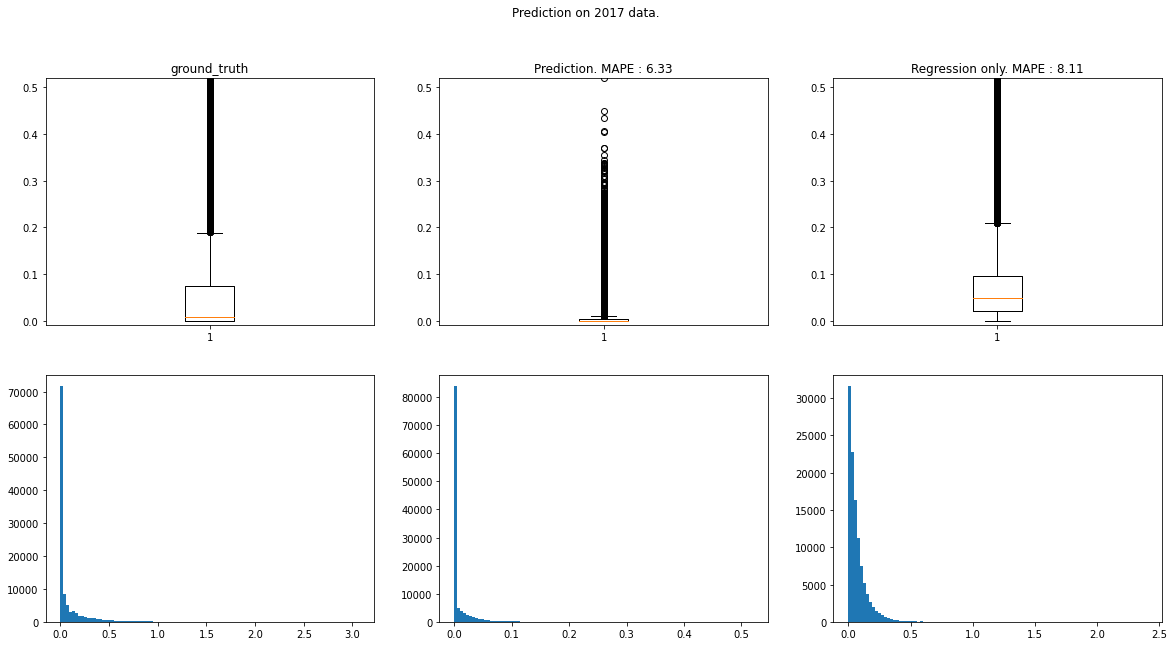

In [28]:
box_plot(prediction_x_test)

In [ ]:
del x_train
del y_cls_train
del y_reg_train

del x_test
del y_cls_test
del y_reg_test

# Make a submission

In [ ]:
test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final_by_day.zip")
# test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final.zip")

## create submission dataset

In [ ]:
submission = pd.DataFrame(test_set[["Id"]])

## get same columns as before for test_set

In [ ]:
test_set = test_set[columns]

## normalize same way test_set

In [ ]:
test_set = normalize(test_set,normalization_infos)

In [ ]:
test_set.head()

## Predict test_set for submission

In [ ]:
y_cls_pred = model_cls.predict(test_set)

In [ ]:
y_reg_pred = model_reg.predict(test_set)

In [ ]:
cls_temp = y_cls_pred[:,0] < y_cls_pred[:,1]
y_cls_pred = np.array([[0,1] if c else [1,0] for c in cls_temp])

In [ ]:
sns.histplot(x=y_cls_pred[:,1], hue=y_cls_pred[:,1])
plt.show()

In [ ]:
print(avg_raining_ratio)

In [ ]:
submission["cls_pred"] = pd.Series(y_cls_pred.T[0])
submission["reg_pred"] = y_reg_pred

In [ ]:
submission["Prediction"] = submission["cls_pred"] * submission["reg_pred"]

In [ ]:
submission.head(50)

In [ ]:
submission[["Id","Prediction"]].to_csv("../submissions/submission_ann.csv", index=False)

lon_idx lat_idx id month penser à normaliser les datasets avec les valeurs max d'un des dataset